In [1]:
import os
import ast
import sys
import re
import json
import itertools
import gc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import stanza
from gensim.models import KeyedVectors
from collections import defaultdict
from nltk import FreqDist, word_tokenize

sys.path.append("/home/piotr/projects/twitter/src")
from twitter_tools.utils import read_files, clean_tweets
from tqdm.notebook import tqdm
tqdm.pandas()

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
def lemmatize(text:list, stanza_model):
    result = []
    doc = stanza_model(text)
    _ = [result.append([word.lemma for word in sent.words].pop()) for sent in doc.sentences]
    result = [word for word in result if re.match("\w+", word)]
    return result

#### Load the data:

In [3]:
data = pd.DataFrame()
for dat in tqdm(read_files("/home/piotr/projects/twitter/data/clean", 84)):
    dat = dat.loc[np.logical_not(dat.english)] #skip English
    dat.loc[:,("preprocessed")] = dat["preprocessed"].apply(lambda x: ast.literal_eval(x))
    data = data.append(dat[["full_text", "source", "preprocessed", "day"]])
data.reset_index(inplace = True, drop = True)
print(f"Data size {data.shape[0]}")

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s



Data size5514653


## 1. Analysis of the entire dataset:

#### Number of tweets by day:

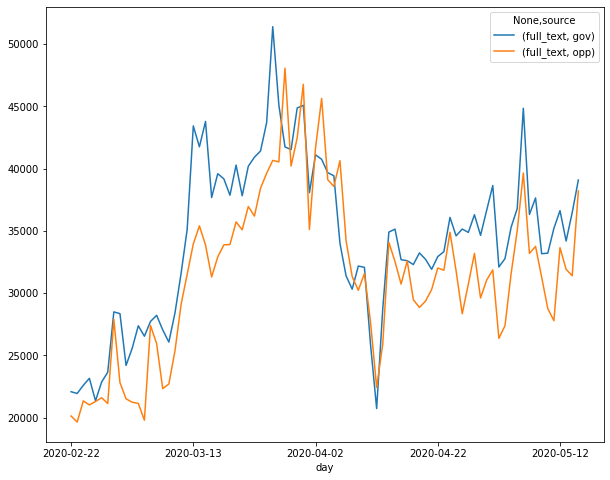

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
data[["day","source","full_text"]].groupby(["day", "source"]).count().reset_index("source").pivot(columns = "source").plot(ax = ax)
plt.show()

#### Vocabulary distribution (lemmatized and without stopwords)
In the first step of the exploratory analysis, I look at the frequency distribution of lemmas in the entire corpus (with exclusion of stopwords, which were removed at the preprocessing step). 

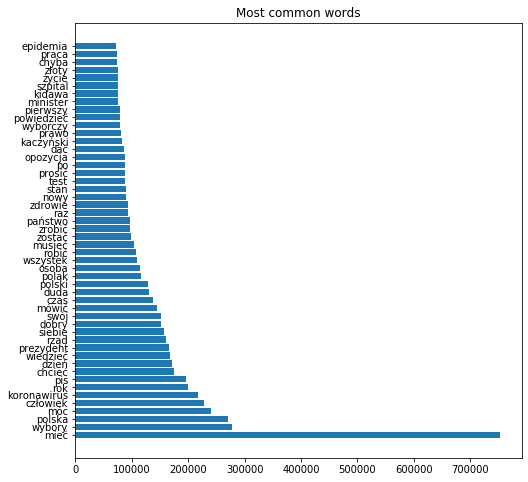

In [8]:
%matplotlib inline
freq = FreqDist(list(itertools.chain.from_iterable(data["preprocessed"].tolist())))
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Most common words")
ax.barh(y = [word[0] for word in freq.most_common(50)], 
        width = [word[1] for word in freq.most_common(50)])
plt.show()

#### Party-specific vocabulary distribution (lemmatized and without stopwords)
Secondly, I look at party-specific vocabulary, defined as tokens that were included in the top 100 most frequent tokens of one party, but not the other.

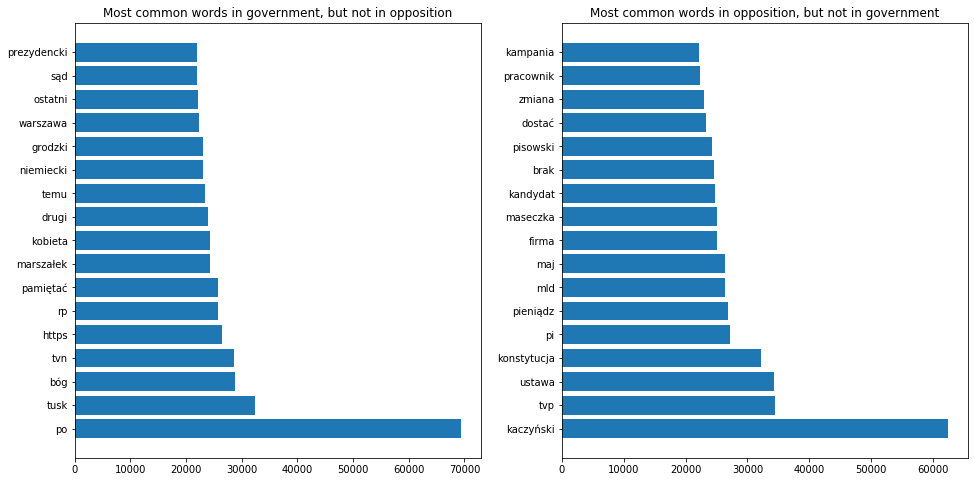

In [11]:
freqs = dict() #store freq dist for both parties
for source in ["gov","opp"]:
    freqs[source] = FreqDist(list(itertools.chain.from_iterable([tweet 
                                          for i, tweet in enumerate(data["preprocessed"].tolist()) 
                                          if data["source"].iloc[i] == source])))

words = dict() #store "unique" tokens for both parties
words["gov"] = [word for word in freqs["gov"].most_common(100) if word[0] not in [elem[0] for elem in freqs["opp"].most_common(100)]]
words["opp"] = [word for word in freqs["opp"].most_common(100) if word[0] not in [elem[0] for elem in freqs["gov"].most_common(100)]]

%matplotlib inline
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Most common words in government, but not in opposition")
ax.barh(y = [word[0] for word in words["gov"]], width = [word[1] for word in words["gov"]])
ax = fig.add_subplot(1, 2, 2)
ax.set_title("Most common words in opposition, but not in government")
ax.barh(y = [word[0] for word in words["opp"]], width = [word[1] for word in words["opp"]])
plt.show()

The main conclusion seems to be that names of politicians and entities related to one's opposing party are mentioned more frequently than to one's party. This relates to both individual politicians ("Kaczynski", "Tusk") as well as news broadcasters ("tvp", "tvn").

#### Party-specific vocabulary distribution by day (lemmatized and without stopwords)
I re-run the same analysis, but this time looking at the most popular tokens amongst partisans of both groups in a given day.

In [16]:
#create a dictionary of dictionaries to store "unique" tokens for each day
parties = ["gov", "opp"]
words = dict().fromkeys(parties) 
words = {k:dict() for k in words}

#iterate over sources to gather data
for day, subdata in tqdm(data.groupby(["day"])):
    #first get daily frequency distribution of each party
    freqs = dict()
    for party in parties:
        freqs[party] = FreqDist(list(itertools.chain.from_iterable([tweet 
                                          for i, tweet in enumerate(subdata["preprocessed"].tolist()) 
                                          if subdata["source"].iloc[i] == party])))
    #second, get "unique" tokens for a given day 
    for i, party in enumerate(parties):
        words[party][day] = [word for word in freqs[party].most_common(100) if word[0] not in [elem[0] for elem in freqs[parties[i-1]].most_common(100)]]

#most popular token per party day:
top = {party:{day:token[0] for day, token in freq.items()} for party, freq in words.items()}

#### Counts of words referencing tokens similar to a specific topic every day
Finally, I look at the number of partisans that mentioned words related to two specific topics: *coronavirus* and *elections* (presidential elections). To approximate that, I took top 500 tokens closest in the fastText embedding space. The tokens were then lemmatized, resulting in final set of roughly 350 per topic.

In [4]:
if os.path.isfile("topic_vocab.json"):
    topic_vocab = json.load(open("topic_vocab.json","r"))
else:
    fasttext = KeyedVectors.load_word2vec_format("/home/piotr/nlp/cc.pl.300.vec") #embeddings model
    topic_vocab = dict() #store closest words:
    topic_vocab["wirus"] = ["wirus"] + [word[0] for word in fasttext.most_similar("wirus", topn = 1000)]
    topic_vocab["wybory"] = ["wybory"] + [word[0] for word in fasttext.most_similar("wybory", topn = 1000)]
    json.dump(topic_vocab, open("topic_vocab.json","w"))
    #lemmatize:
    nlp_pl = stanza.Pipeline("pl", processors = "tokenize,mwt,pos,lemma",use_gpu = True, tokenize_no_ssplit = True)
    topic_vocab = {k:lemmatize(words, nlp_pl) for k, words in topic_vocab.items()}
    #drop duplicates keeping ordering:
    topic_vocab = {k:[word for i, word in enumerate(words) if i not in words[:n]] for k, word in topic_vocab.items()}
    #dump:
    json.dump(topic_vocab, open("topic_vocab.json","w"))
    del(fasttext, nlp_pl)
    gc.collect()

To get the counts, I get the length of set intersection betweeen the topic words and tokens used in each tweet:

In [ ]:
for topic, words in topic_vocab.items():
    data[topic] = data["preprocessed"].apply(lambda x: len(set(x).intersection(words)))

#### Plot of the frequency of topic-related tokens

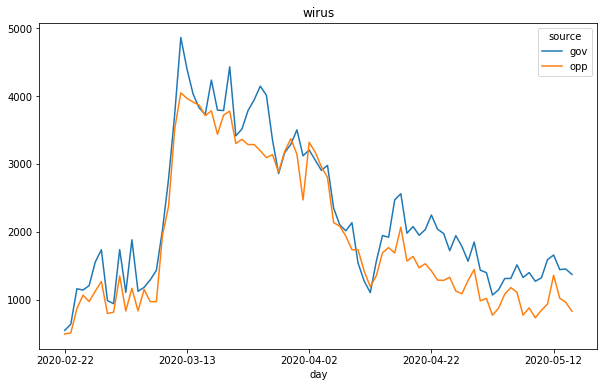

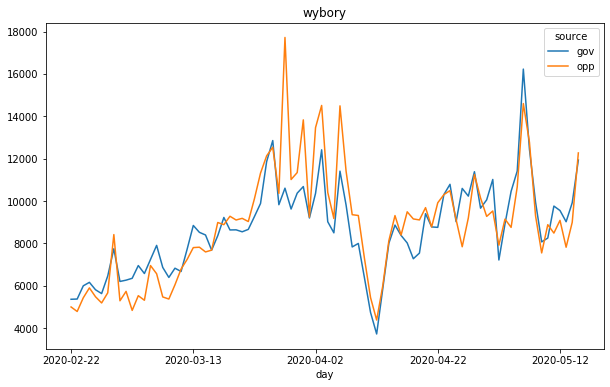

In [162]:
topic_counts = data.groupby(["source","day"]).sum()
ax = topic_counts.reset_index() \
                                .melt(id_vars = ["day", "source"], 
                                      value_vars = ["wirus", "wybory"], 
                                      var_name = ["topic"]) \
                                .pivot_table(index = ["day","topic"], 
                                             columns = ["source"], 
                                             values = "value") \
                                .reset_index().groupby("topic").plot(x = "day", figsize = (10,6))
_ = [ax[i].set_title(ax.index[i]) for i in range(len(ax))]
plt.show()

## 2. Re-do the same analysis after dropping the duplicates (i.e. retweets that were re-tweeted more than once)

In [147]:
data.drop_duplicates(subset = ("full_text", "source"), inplace = True)
print(f"Data size {data.shape[0]}")

Data size 3547612


#### Number of tweets by day:

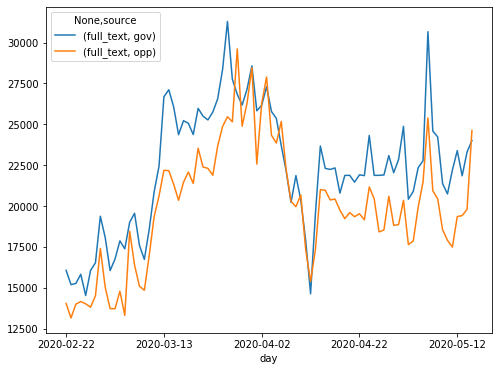

In [161]:
data[["day","source","full_text"]].groupby(["day", "source"]).count().reset_index("source").pivot(columns = "source").plot(figsize = (8, 6))
plt.show()

#### Vocabulary distribution (lemmatized and without stopwords)
In the first step of the exploratory analysis, I look at the frequency distribution of lemmas in the entire corpus (with exclusion of stopwords, which were removed at the preprocessing step). 

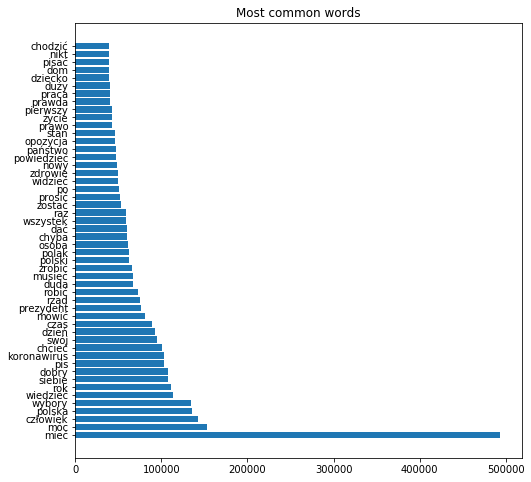

In [163]:
%matplotlib inline
freq = FreqDist(list(itertools.chain.from_iterable(data["preprocessed"].tolist())))
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Most common words")
ax.barh(y = [word[0] for word in freq.most_common(50)], 
        width = [word[1] for word in freq.most_common(50)])
plt.show()

#### Party-specific vocabulary distribution (lemmatized and without stopwords)
Secondly, I look at party-specific vocabulary, defined as tokens that were included in the top 100 most frequent tokens of one party, but not the other.

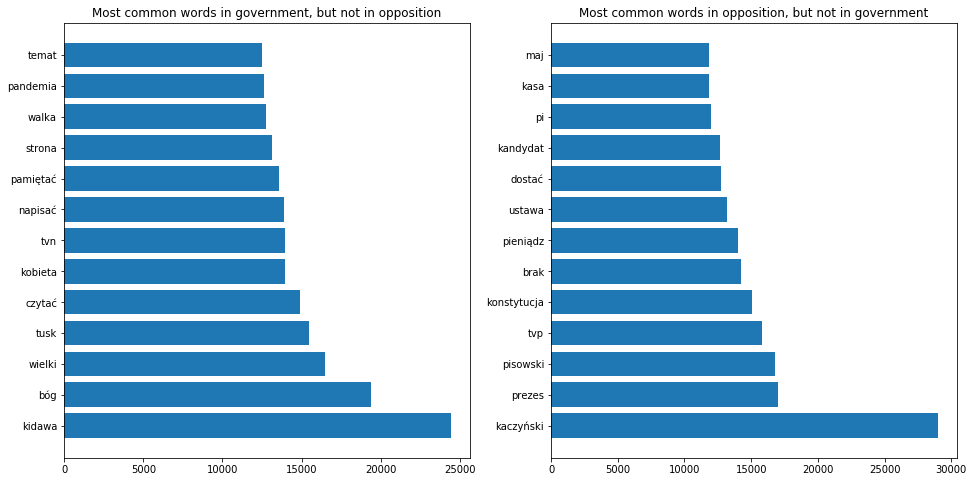

In [164]:
freqs = dict() #store freq dist for both parties
for source in ["gov","opp"]:
    freqs[source] = FreqDist(list(itertools.chain.from_iterable([tweet 
                                          for i, tweet in enumerate(data["preprocessed"].tolist()) 
                                          if data["source"].iloc[i] == source])))

words = dict() #store "unique" tokens for both parties
words["gov"] = [word for word in freqs["gov"].most_common(100) if word[0] not in [elem[0] for elem in freqs["opp"].most_common(100)]]
words["opp"] = [word for word in freqs["opp"].most_common(100) if word[0] not in [elem[0] for elem in freqs["gov"].most_common(100)]]

%matplotlib inline
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Most common words in government, but not in opposition")
ax.barh(y = [word[0] for word in words["gov"]], width = [word[1] for word in words["gov"]])
ax = fig.add_subplot(1, 2, 2)
ax.set_title("Most common words in opposition, but not in government")
ax.barh(y = [word[0] for word in words["opp"]], width = [word[1] for word in words["opp"]])
plt.show()

The main conclusion seems to be that names of politicians and entities related to one's opposing party are mentioned more frequently than to one's party. This relates to both individual politicians ("Kaczynski", "Tusk") as well as news broadcasters ("tvp", "tvn").

In [165]:
for topic, words in topic_vocab.items():
    data[topic] = data["preprocessed"].apply(lambda x: len(set(x).intersection(words)))

#### Plot of the frequency of topic-related tokens

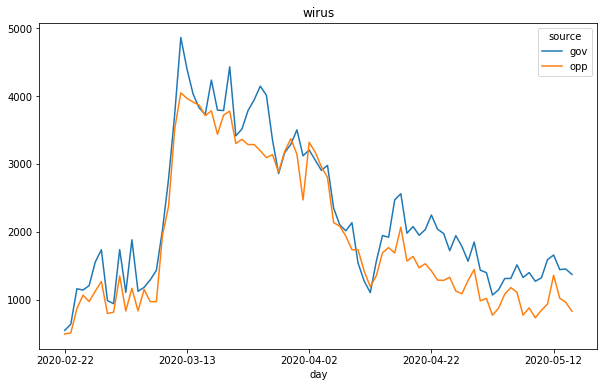

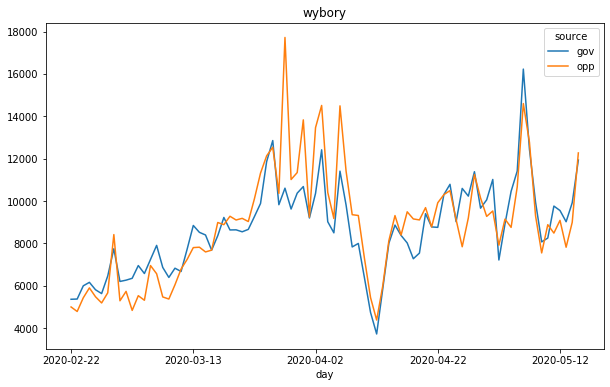

In [166]:
topic_counts = data.groupby(["source","day"]).sum()
ax = topic_counts.reset_index() \
                                .melt(id_vars = ["day", "source"], 
                                      value_vars = ["wirus", "wybory"], 
                                      var_name = ["topic"]) \
                                .pivot_table(index = ["day","topic"], 
                                             columns = ["source"], 
                                             values = "value") \
                                .reset_index().groupby("topic").plot(x = "day", figsize = (10,6))
_ = [ax[i].set_title(ax.index[i]) for i in range(len(ax))]
plt.show()

## 3. Re-do the same analysis without re-tweets at all:

In [167]:
data = pd.DataFrame()
for dat in tqdm(read_files("/home/piotr/projects/twitter/data/clean", 84)):
    dat = dat.loc[np.logical_not(dat.english | dat.retweet)] #skip English or re-tweets
    dat.loc[:,("preprocessed")] = dat["preprocessed"].apply(lambda x: ast.literal_eval(x))
    data = data.append(dat[["full_text", "source", "preprocessed", "day"]])
data.reset_index(inplace = True, drop = True)
print(f"Data size{data.shape[0]}")

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7efe25b50c10>
Traceback (most recent call last):
  File "/home/piotr/anaconda3/envs/nlp/lib/python3.8/weakref.py", line 345, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 



Data size5628752


#### Vocabulary distribution (lemmatized and without stopwords)
In the first step of the exploratory analysis, I look at the frequency distribution of lemmas in the entire corpus (with exclusion of stopwords, which were removed at the preprocessing step). 

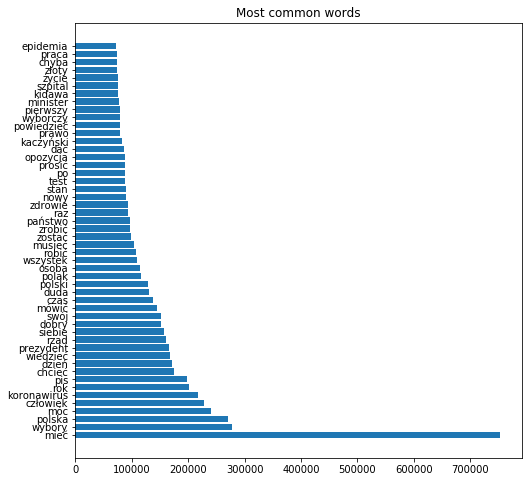

In [168]:
%matplotlib inline
freq = FreqDist(list(itertools.chain.from_iterable(data["preprocessed"].tolist())))
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Most common words")
ax.barh(y = [word[0] for word in freq.most_common(50)], 
        width = [word[1] for word in freq.most_common(50)])
plt.show()

#### Party-specific vocabulary distribution (lemmatized and without stopwords)
Secondly, I look at party-specific vocabulary, defined as tokens that were included in the top 100 most frequent tokens of one party, but not the other.

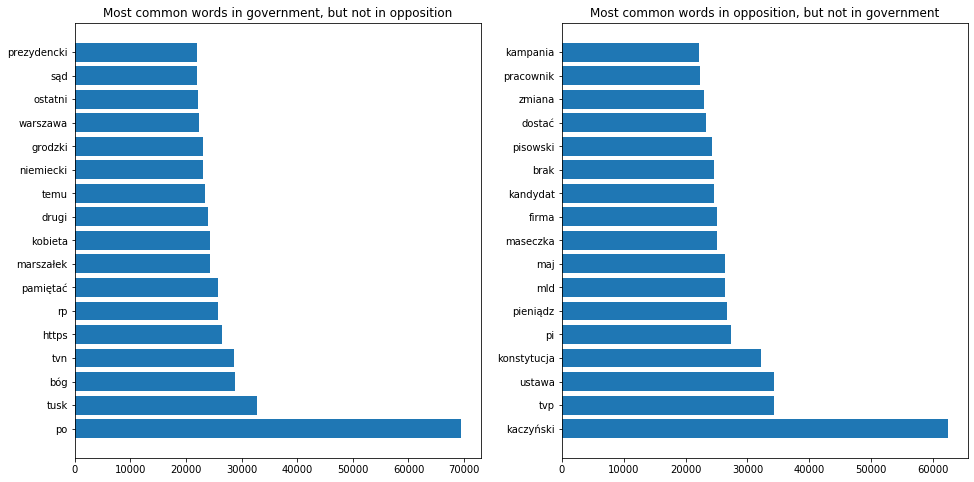

In [169]:
freqs = dict() #store freq dist for both parties
for source in ["gov","opp"]:
    freqs[source] = FreqDist(list(itertools.chain.from_iterable([tweet 
                                          for i, tweet in enumerate(data["preprocessed"].tolist()) 
                                          if data["source"].iloc[i] == source])))

words = dict() #store "unique" tokens for both parties
words["gov"] = [word for word in freqs["gov"].most_common(100) if word[0] not in [elem[0] for elem in freqs["opp"].most_common(100)]]
words["opp"] = [word for word in freqs["opp"].most_common(100) if word[0] not in [elem[0] for elem in freqs["gov"].most_common(100)]]

%matplotlib inline
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Most common words in government, but not in opposition")
ax.barh(y = [word[0] for word in words["gov"]], width = [word[1] for word in words["gov"]])
ax = fig.add_subplot(1, 2, 2)
ax.set_title("Most common words in opposition, but not in government")
ax.barh(y = [word[0] for word in words["opp"]], width = [word[1] for word in words["opp"]])
plt.show()

The main conclusion seems to be that names of politicians and entities related to one's opposing party are mentioned more frequently than to one's party. This relates to both individual politicians ("Kaczynski", "Tusk") as well as news broadcasters ("tvp", "tvn").

In [170]:
for topic, words in topic_vocab.items():
    data[topic] = data["preprocessed"].apply(lambda x: len(set(x).intersection(words)))

#### Plot of the frequency of topic-related tokens

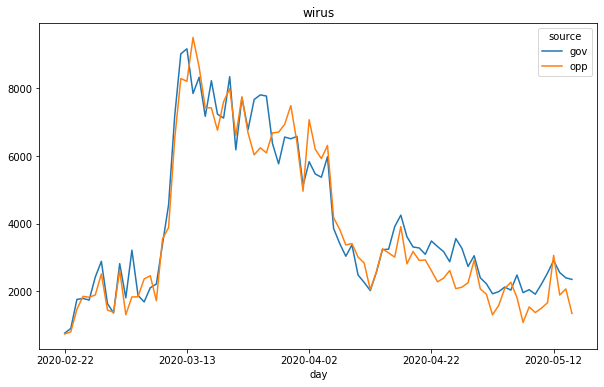

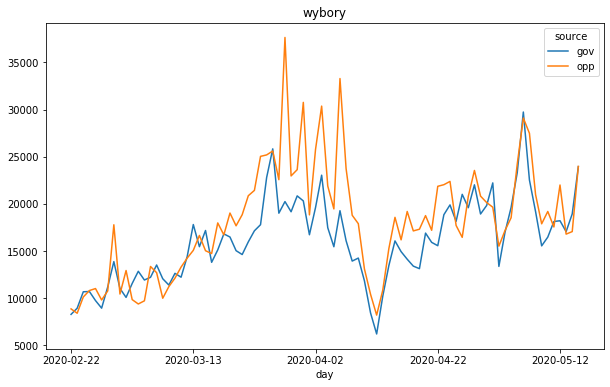

In [171]:
topic_counts = data.groupby(["source","day"]).sum()
ax = topic_counts.reset_index() \
                                .melt(id_vars = ["day", "source"], 
                                      value_vars = ["wirus", "wybory"], 
                                      var_name = ["topic"]) \
                                .pivot_table(index = ["day","topic"], 
                                             columns = ["source"], 
                                             values = "value") \
                                .reset_index().groupby("topic").plot(x = "day", figsize = (10,6))
_ = [ax[i].set_title(ax.index[i]) for i in range(len(ax))]
plt.show()